In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("/content/final_dga_dataset_cleaned.csv")

# Lowercase + remove TLD again for safety
df['domain'] = df['domain'].str.lower()
df['domain'] = df['domain'].str.split('.').str[0]

X = df['domain'].values
y = df['label'].values

# Character-level tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences
MAX_LEN = 40   # 40 is enough for most domains
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (128000, 40)
Test shape: (32000, 40)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input

vocab_size = len(tokenizer.word_index) + 1

model_binary = Sequential([
    Input(shape=(MAX_LEN,)),

    Embedding(input_dim=vocab_size, output_dim=32),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model_binary.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_binary.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 32)         │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 38, 128)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,985 (85.88 KB)

 Trainable params: 21,985 (85.88 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model_binary.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8299 - loss: 0.3849 - val_accuracy: 0.9266 - val_loss: 0.1736
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9354 - loss: 0.1587 - val_accuracy: 0.9452 - val_loss: 0.1276
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9524 - loss: 0.1200 - val_accuracy: 0.9606 - val_loss: 0.1015
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9625 - loss: 0.0980 - val_accuracy: 0.9646 - val_loss: 0.0912
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9695 - loss: 0.0839 - val_accuracy: 0.9595 - val_loss: 0.0967


In [4]:
loss, accuracy = model_binary.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9612 - loss: 0.0948
Test Accuracy: 0.9617499709129333


In [5]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model_binary.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
[[15694   306]
 [  918 15082]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16000
           1       0.98      0.94      0.96     16000

    accuracy                           0.96     32000
   macro avg       0.96      0.96      0.96     32000
weighted avg       0.96      0.96      0.96     32000



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
ROC curve saved as /content/roc_curve.png


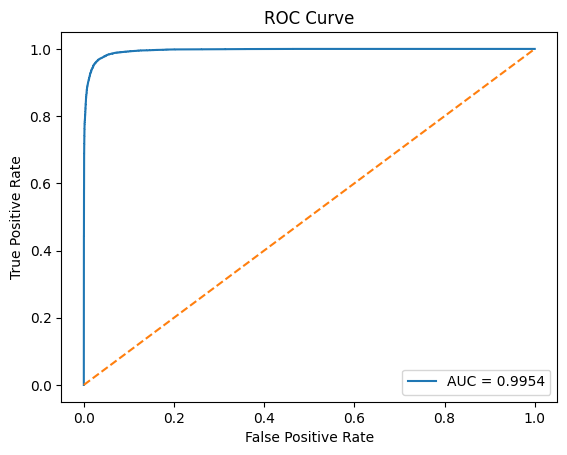

AUC Score: 0.995374662109375


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model_binary.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = %0.4f" % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("/content/roc_curve.png") # Save before showing
print("ROC curve saved as /content/roc_curve.png")
plt.show()

print("AUC Score:", roc_auc)
model_binary.save("../models/binary_cnn_model.keras")